## MLE computation

compute the MLE to check quality of estimates and code functionality.

In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


In [2]:
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")
#using .Src

Main.Src

In [71]:
using DataFrames, Optim, Plots, ForwardDiff, LinearAlgebra, Distributions, Colors

#### tools that need to be integrated to src

In [105]:
function correlation_covariance_matrix(eval_pt::Vector{Float64}, prm_keys::Vector, hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0, obs_late::Bool=false, t_obs::Float64=100.0)
    fim = - ForwardDiff.hessian(x -> Src.compute_ll(x, prm_keys, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs), eval_pt)
    cov = inv(fim)
    cor = [cov[i,j] / sqrt(cov[i,i]*cov[j,j]) for i in range(1, size(cov,1)), j in range(1, size(cov,2))]
    return cor, cov
end

function plot_mult_restart_mles(inits::Matrix, mles::Matrix, ind_best::Int64, prm_keys::Vector; compare::Bool=true, N::Int64=20)

    n_prms = length(prm_keys)
    
    if n_prms == 1
        p = plot(mles[:,1], label="MLEs $(prm_keys[1])", title="Multiple restart MLE of $(prm_keys[1])",color="#165DB1",linewidth=2, ylabel="parameter value", xlabel="restart index")
        if hprm !== nothing && hasproperty(hprm, prm_keys[1])
            hline!([getproperty(hprm, prm_keys[1])], linestyle=:dash, linewidth=2, color=:black, label="true parameter")
        end
        scatter!(1:N, mles[:,1], markershape=:square, markersize=2, color="#165DB1", label="")
        if compare
            plot!(inits[:,1], label="inits", color="#9ABCE4",linewidth=1)
            scatter!(1:N, inits[:,1], markershape=:square, markersize=2, color="#9ABCE4", label="")
        end
        scatter!([ind_best], [mles[ind_best, 1]], markershape=:x, markerstrokewidth=5, markersize=8, color="#F7811E", label="best estimate")
        return p
    else
        # subplot 1
        p1 = plot(mles[:,1], label="MLEs $(prm_keys[1])", title="Multiple restart MLE of $(prm_keys[1])",color="#165DB1",linewidth=2, ylabel="parameter value", xlabel="restart index")
        if hprm !== nothing && hasproperty(hprm, prm_keys[1])
            hline!([getproperty(hprm, prm_keys[1])], linestyle=:dash, linewidth=2, color=:black, label="true parameter")
        end
        scatter!(1:N, mles[:,1], markershape=:square, markersize=2, color="#165DB1", label="")
        if compare
            plot!(inits[:,1], label="inits", color="#9ABCE4",linewidth=1)
            scatter!(1:N, inits[:,1], markershape=:square, markersize=2, color="#9ABCE4", label="")
        end
        scatter!([ind_best], [mles[ind_best, 1]], markershape=:x, markerstrokewidth=5, markersize=8, color="#F7811E", label="best estimate")
        
        # subplot 2
        p2 = plot(mles[:,2], label="MLEs $(prm_keys[2])", title="Multiple restart MLE of $(prm_keys[2])",color="#165DB1",linewidth=2, ylabel="parameter value", xlabel="restart index")
        if hprm !== nothing && hasproperty(hprm, prm_keys[2])
            hline!([getproperty(hprm, prm_keys[2])], linestyle=:dash, linewidth=2, color=:black, label="true parameter")
        end
        scatter!(1:N, mles[:,2], markershape=:square, markersize=2, color="#165DB1", label="")
        if compare
            plot!(inits[:,2], label="inits", color="#9ABCE4",linewidth=1)
            scatter!(1:N, inits[:,2], markershape=:square, markersize=2, color="#9ABCE4", label="")
        end
        scatter!([ind_best], [mles[ind_best, 2]], markershape=:x, markerstrokewidth=5, markersize=8, color="#F7811E", label="best estimate")
        return plot(p1, p2, layout=(1,2), size=(800,400))
    end
end

function plot_mult_restart_losses(inits_loss::Vector, losses::Vector, ind_best::Int64; compare::Bool=false, N::Int64=20)
    plot(losses, label="MLEs", color="#165DB1",linewidth=2, title="Loss evolution of multiple restart MLE", ylabel = "loss value", xlabel="restart index")
    scatter!(1:N, losses, markershape=:square, markersize=2, color="#165DB1", label="")

    if compare
        plot!(inits_loss, label="init", color="#9ABCE4",linewidth=1)
        scatter!(1:N, inits_loss, markershape=:square, markersize=2, color="#9ABCE4", label="")
    end

    scatter!([ind_best], [losses[ind_best]], markershape=:x, markerstrokewidth=5, markersize=8, color="#F7811E", label="lowest")
end

"""
    plot_gaussian(mle::Vector, cov::Matrix)

Visualizes a bivariate Gaussian distribution given its mean (MLE) and covariance.

# Arguments
- `mle::Vector`: A 2-element vector `[a_mean, m_mean]` representing the mean (maximum likelihood estimate) of the distribution.
- `cov::Matrix`: A 2×2 covariance matrix of the Gaussian.

# Returns
- `heatmap_plot`: A 2D heatmap of the probability density function over a grid centered around the MLE, with the MLE marked.
- `surface_plot`: A combined 3D surface plot from two different viewpoints, also showing the MLE as a point.
"""
function plot_gaussian(mle::Vector, cov::Matrix, prm_keys::Vector)

    if length(mle) == 1
        dens = Normal(mle[1], sqrt(cov[1]))
        x = range(mle[1] - 3*sqrt(cov[1,1]), mle[1] + 3*sqrt(cov[1,1]), length=500)
        pdf_evals = pdf.(dens, x)
        surface_plot = plot(x,pdf_evals, xlabel=prm_keys[1], linewidth=2, color="#165DB1", label="")
        heatmap_plot = nothing
    else
        # set custom color gradient
        tum_blues = [ "#D7E4F4", "#C2D7EF", "#9ABCE4", "#5E94D4", "#165DB1", "#14519A", "#114584", "#0E396E", "#0A2D57", "#072140"]
        tum_cgrad = cgrad(tum_blues, categorical=false)

        cov = Symmetric((cov + cov') / 2) # ensure numerical stability
        dens = MvNormal(mle, cov)
        
        # plotting ranges
        d = max(3*sqrt(cov[1,1]),3*sqrt(cov[2,2])) # make axes comparable
        a = range(mle[1]-d, mle[1]+d, length=500)
        m = range(mle[2]-d, mle[2]+d, length=500)
        pdf_evals = [pdf(dens, [ai, mi]) for mi in m, ai in a]

        # create heatmap
        heatmap_plot = heatmap(a,m,pdf_evals, xlabel=prm_keys[1], ylabel=prm_keys[2], color=tum_cgrad, colorbar=false)

        # create 3D plots from different viewpoints
        v1 = plot(a, m, pdf_evals, st=:surface, xlabel=prm_keys[1], ylabel=prm_keys[2], color=tum_cgrad, colorbar=false)
        v2 = plot(m, a, pdf_evals', st=:surface, xlabel=prm_keys[1], ylabel=prm_keys[2], color=tum_cgrad, colorbar=false)
        surface_plot = plot(v1,v2, layout=(1,2), size=(800,400))
    end

    return heatmap_plot, surface_plot
end

plot_gaussian

### create simulated data obs

In [58]:
# define which parameters should be inferred and choose test point
a_true = 1.5
m_true = 0.45

prm_keys = [:a, :m]
#prm_keys = [:a]
exp_point = [a_true, m_true]
#exp_point = [a_true];

2-element Vector{Float64}:
 1.5
 0.45

In [59]:
# further settings
t_fixed = true

true

In [60]:
# generate observation data
noise = 0.01
M = 100
hprm = Src.Hyperprm(1.0, 1.0, a_true, m_true, M, noise)

Main.Src.Hyperprm(1.0, 1.0, 1.5, 0.45, 100, 0.01)

In [93]:
function assess_practical_identifiability(point::Vector, prm_keys::Vector, hprm::Src.Hyperprm; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0, obs_late::Bool=false, t_obs::Float64=100.0, N::Int64=20)
    
    # create data observations and include noise
    sol_true = Src.sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs)
    Src.randomize_data!(sol_true, hprm.noise); # make data noisy

    # compute MLE via multiple restart optimizations
    inits, inits_loss, mles, losses, best_loss_ind, converged = Src.mult_restart_mle(N, prm_keys, hprm, sol_true, t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs)
    mle = mles[best_loss_ind,:]
    plot_mles = plot_mult_restart_mles(inits, mles, best_loss_ind, prm_keys, N=N)
    plot_losses = plot_mult_restart_losses(inits_loss, losses,best_loss_ind, N=N)

    # compute covariance/ correlation Matrix
    cor, cov = correlation_covariance_matrix(mle, prm_keys, hprm, sol_true, t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs)

    # plot MvNormals (Fisher Approximation)
    gaussian_heatmap, gaussian_surface = plot_gaussian(mle,cov,prm_keys)

    return return (
        mle = mle,
        plot_mles = plot_mles,
        plot_losses = plot_losses,
        cor = cor,
        cov = cov,
        gaussian_heatmap = gaussian_heatmap,
        gaussian_surface = gaussian_surface,
    )
end

assess_practical_identifiability (generic function with 1 method)

In [106]:
result = assess_practical_identifiability(exp_point, prm_keys, hprm, t_fixed=t_fixed)

(mle = [1.5048797622351302, 0.4514487059215832], plot_mles = Plot{Plots.GRBackend() n=12}, plot_losses = Plot{Plots.GRBackend() n=3}, cor = [1.0 0.9976424562542734; 0.9976424562542778 1.0], cov = [0.003670405118808068 0.0011168718918098733; 0.0011168718918098783 0.0003414623891389472], gaussian_heatmap = Plot{Plots.GRBackend() n=1}, gaussian_surface = Plot{Plots.GRBackend() n=2})

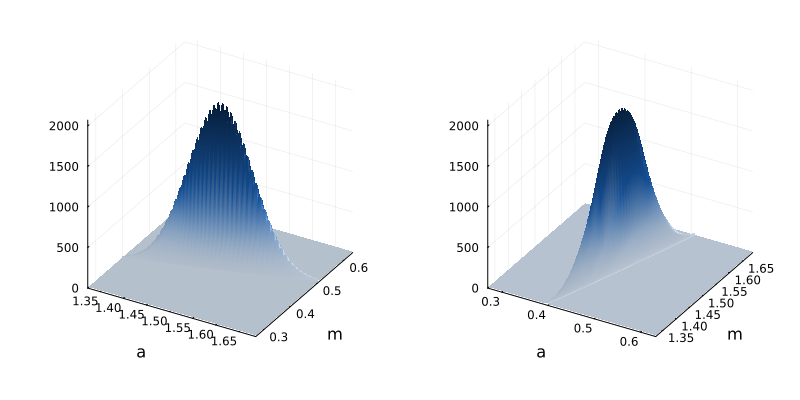

In [107]:
result.gaussian_surface

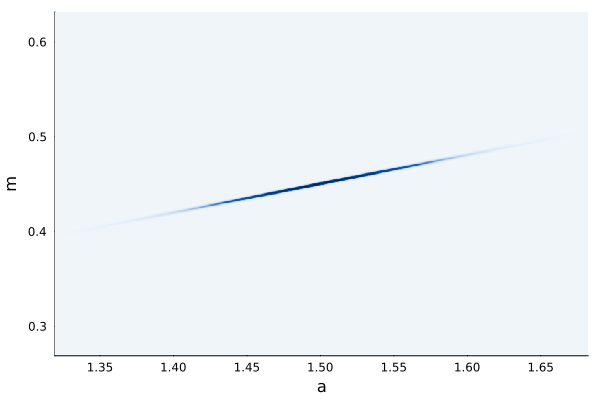

In [103]:
result.gaussian_heatmap